# Test plan

## Use ADM for evaluating the interactive process
	Needs work from Vesa to overcome technical challenges of combining ADM code and interactive K-RVEA 
	PPSN version (Python) or JMetal version?, implement ADM in Matlab
	Timetable?	
			
			
			
## Algorithms to be tested	
	Interactive K-RVEA vs. interactive RVEA (usefulness of surrogate)
	Interactive K-RVEA vs. non-adaptive surrogate + interaction (usefulness of intelligent training)
	Give Vesa access to interactive RVEA
	Modify interactive K-RVEA for non-adaptive surrogates --->>> DO THIS
			
## Test problems		
	DTLZ2, DTLZ5, DTLZ7	
	Number of objectives: 3,5,7
	15 independent runs (5 initially + 10 later)
	10 variables for all problems

### Parameters

<table align="left">
 
  <tr>
    <td>maxFE</td>
    <td>100</td>
  </tr>
  <tr>
    <td>r</td>
    <td>0.15</td>
  </tr>
</table>




In [2]:
import operator
import pickle

# Results from PPSN2016 used for reference points and POs
res_all=pickle.load(open("results_2016-04-16.dmp","r"))

import ADM
# Simple test to check it works
# ADM._proj_ref(3, 'DTLZ1', (0.006631727076633065, 0.5551551402005014, 0.0),evals=500)

# Setting up

In [3]:
PO=pickle.load(open("PO.dmp","r"))
print("Total number of PO solutions %i"%len(PO.keys()))

Total number of PO solutions 245


## Generate intial preferences

Initial preferences are calculated and corresponding PO solutions are found  before MATLAB tests. Here we have total of 5 different preference items for each nf

This is to speed up the calcualtions esp due slow initialization of JVM


In [ ]:
reload(ADM)
try:
    preferences=pickle.load(open("preferences.dmp","r"))
except IOError:
    preferences={}
# First we create preferences and find corresponding PO for DTLZ2
for nf in [3,5,7]:
    pref=[]
    for i in range(5):
        ta = ADM.hADM('DTLZ2', nf, nx = 10)
        pref.append(ta.preference)
    preferences[nf]=pref
pickle.dump(preferences,open("preferences.dmp","w"))



In [ ]:
import pickle
import multiprocessing
from joblib import Parallel, delayed
preferences = pickle.load(open("preferences.dmp", "r"))
jobs = max(1, multiprocessing.cpu_count() - 1)
job_args = []
for nf in [3, 5, 7]:
    for pref in preferences[nf]:
        for p in ['DTLZ4', 'DTLZ7']:
            job_args.append({
                    'problem':p,
                    'nf':nf,
                    'preference':pref,
                    'nx':10,
                    })
    
res=map(lambda x:ADM.hADM(**x), [job_arg for job_arg in job_args])
#res = Parallel(n_jobs = jobs)(
#        delayed(ADM.hADM)(**job_arg)
#            for job_arg in job_args
#        )

# Collect results

After running them in matlab...

In [8]:
import pickle
#try:
#    res=pickle.load(res,open("results-2017-12-20.dmp","r"))
#except IOError:

res={}

PO=pickle.load(open("PO.dmp","r"))
def collect(method):

    for p in ["DTLZ2","DTLZ4","DTLZ7"]:
        for nf in [3,5,7]:
            try:
                r=pickle.load(open("%s-%s_%i.dmp"%(method,p,nf),"r"))
            except IOError:
                continue
            res[(nf,method,p)] = []

            for i in range(len(r.keys())):
                n=[]
                l=r[p,nf,int(i)+1][:]
                # best found
                n.append(l[1][-1])
                # initial asp , corresponding PO
                n.append((l[0][0][:],PO[(nf,p,tuple(l[0][0]))]))
                # Delete initial asp
                del l[0][0]
                # Delete duplicate obj values
                del l[1][::2]
                n.append((l[1][:],l[0][:]))      
                res[(nf,method,p)].append(tuple(n))
                
    return res
for m in ["iK-RVEA","iRVEA"]:
    res.update(collect(m))

pickle.dump(res,open("results-2017-12-20.dmp","w"))


In [15]:
import print_results as pr
reload(pr)
from sympy import latex
from IPython.display import Latex, HTML


dfs, missing, error=pr.print_results(res,PO)

for df in dfs:
    print df[0]
    print df[1]

Projections not available: 0
Misconfigured values: 0
iRVEA
  problem  k    median  deviation       min  n   2-sigma  median i  max i
0   DTLZ2  3  0.274959   0.252552  0.147941  5  0.221368        10     10
1   DTLZ4  3  0.443350   0.274872  0.226181  5  0.240931        10     10
2   DTLZ7  3  1.928987   0.071413  1.770275  5  0.062595         1     10
3   DTLZ2  5  0.789634   0.268370  0.116301  5  0.235232        10     10
4   DTLZ4  5  0.698999   0.119010  0.652617  5  0.104315        10     10
5   DTLZ7  5  2.478739   0.114546  2.355541  5  0.100402         1      1
6   DTLZ2  7  0.369145   0.234440  0.251395  5  0.205492        10     10
7   DTLZ4  7  0.926170   0.207990  0.460652  5  0.182308         3     10
8   DTLZ7  7  3.031071   0.099328  2.914138  5  0.087064         1      1
iK-RVEA
  problem  k    median  deviation       min  n   2-sigma  median i  max i
0   DTLZ2  3  0.175632   0.171234  0.114911  5  0.150090        10     10
1   DTLZ4  3  1.001072   0.006183  0.987408  

In [10]:
from IPython.core.display import display, HTML
display(HTML("<H2>LaTeX Tables</H2>"))

for df in dfs:
    print df[0]
    print df[1].to_latex(index=False,float_format = lambda x:"%11.4f" % x)

iRVEA
\begin{tabular}{lrrrrrrrr}
\toprule
problem &  k &      median &   deviation &         min &  n &     2-sigma &  median i &  max i \\
\midrule
  DTLZ2 &  3 &      0.2750 &      0.2526 &      0.1479 &  5 &      0.2214 &        10 &     10 \\
  DTLZ4 &  3 &      0.4433 &      0.2749 &      0.2262 &  5 &      0.2409 &        10 &     10 \\
  DTLZ7 &  3 &      1.9290 &      0.0714 &      1.7703 &  5 &      0.0626 &         1 &     10 \\
  DTLZ2 &  5 &      0.7896 &      0.2684 &      0.1163 &  5 &      0.2352 &        10 &     10 \\
  DTLZ4 &  5 &      0.6990 &      0.1190 &      0.6526 &  5 &      0.1043 &        10 &     10 \\
  DTLZ7 &  5 &      2.4787 &      0.1145 &      2.3555 &  5 &      0.1004 &         1 &      1 \\
  DTLZ2 &  7 &      0.3691 &      0.2344 &      0.2514 &  5 &      0.2055 &        10 &     10 \\
  DTLZ4 &  7 &      0.9262 &      0.2080 &      0.4607 &  5 &      0.1823 &         3 &     10 \\
  DTLZ7 &  7 &      3.0311 &      0.0993 &      2.9141 &  5 &      

D:\local\opt\Miniconda3\envs\research\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


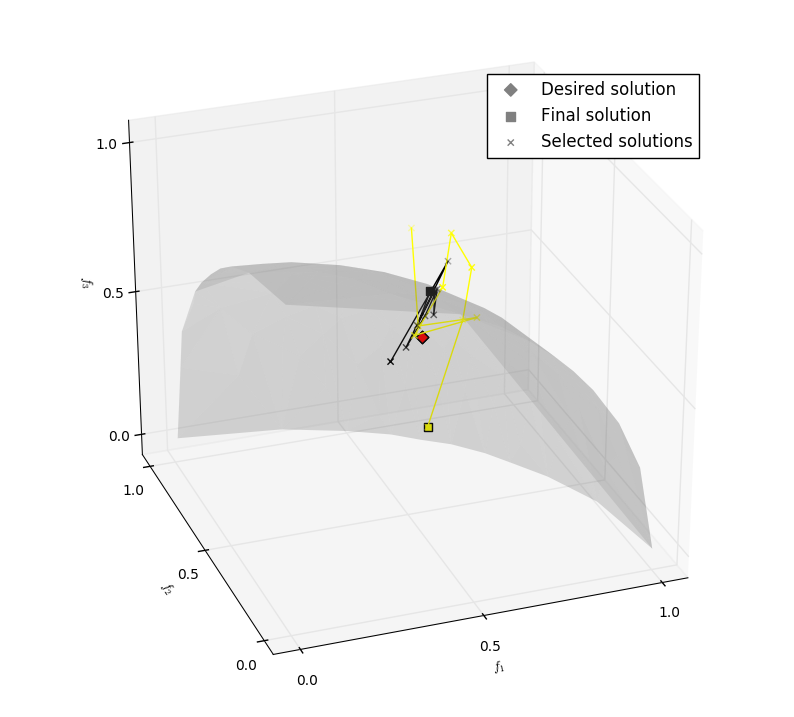

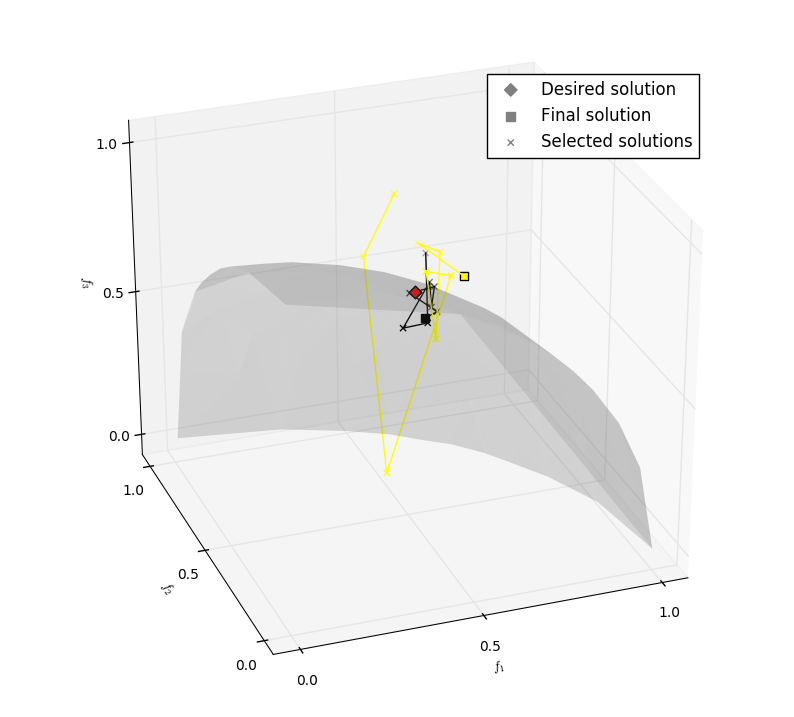

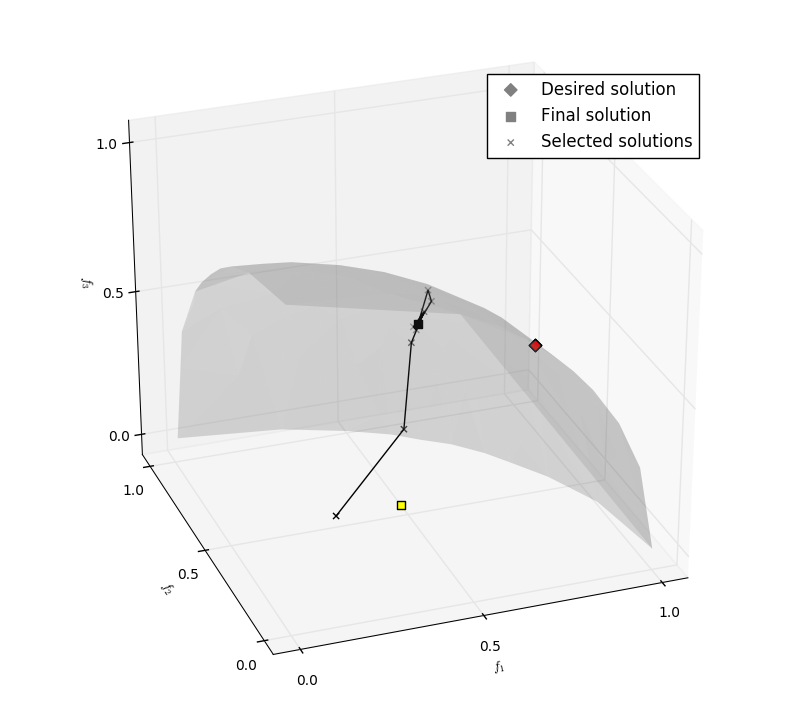

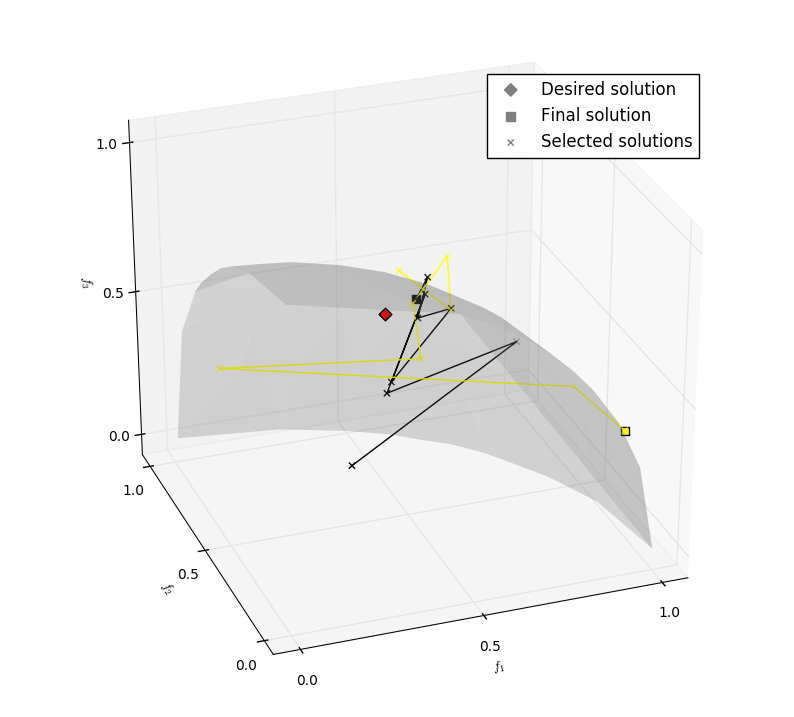

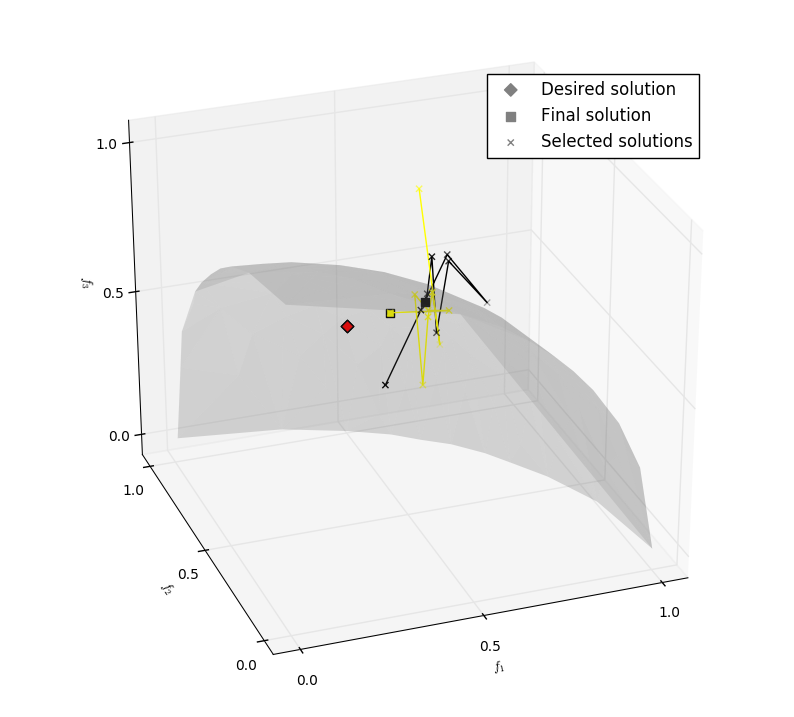

In [11]:
import plot_PPSN2016 as oplt
reload(oplt)
%matplotlib inline
problem="DTLZ2"
display(HTML("<H2>%s ADM selected PO solutions</H2>Yellow is iRVEA and black is iK-RVEA"%problem))
for i in range(5):
    fig=oplt.plot_dec([res[(3,'iK-RVEA',problem)][i],res[(3,'iRVEA',problem)][i]],problem=problem,alpha=.2,
                  figsize=(10,9),legend=True)
    fig.show()


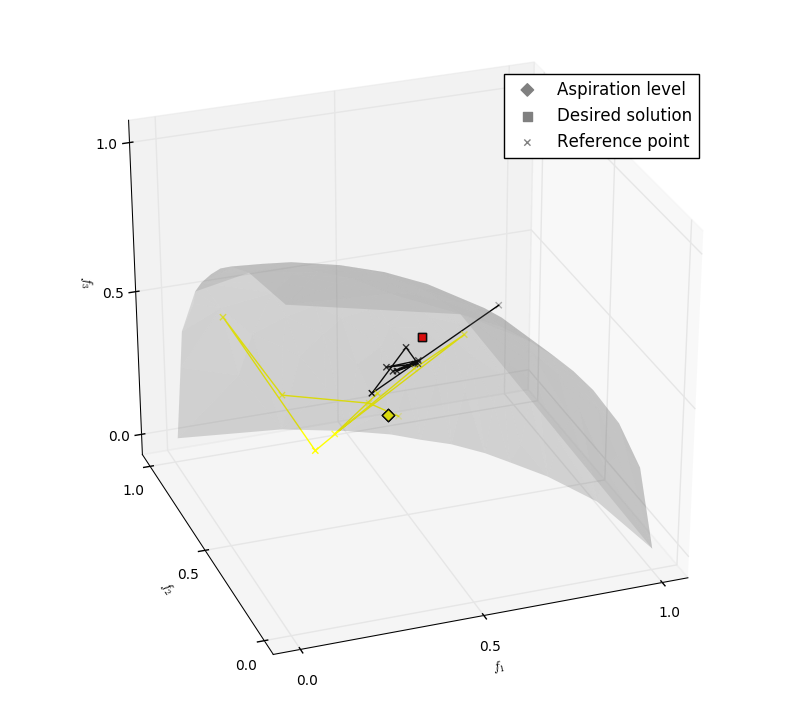

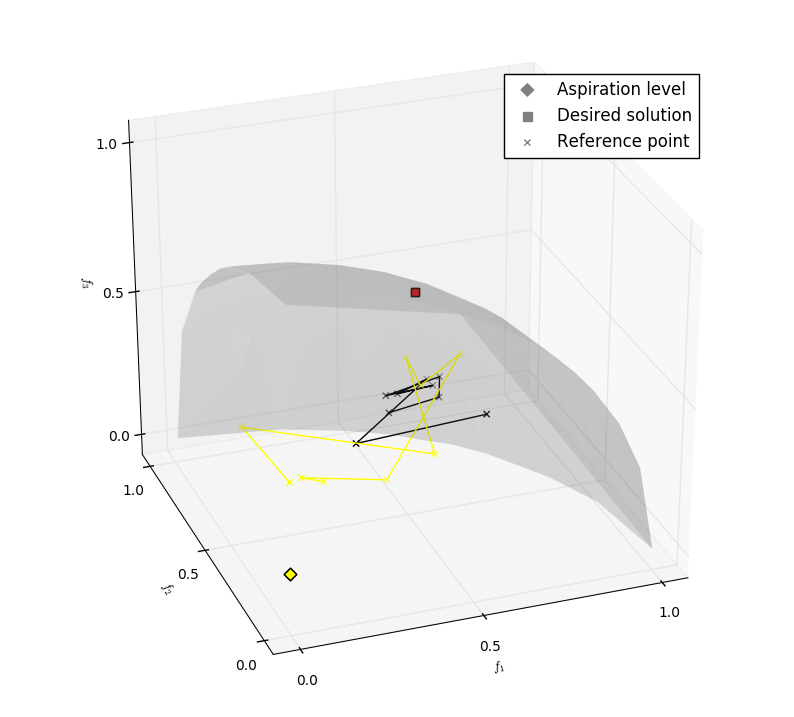

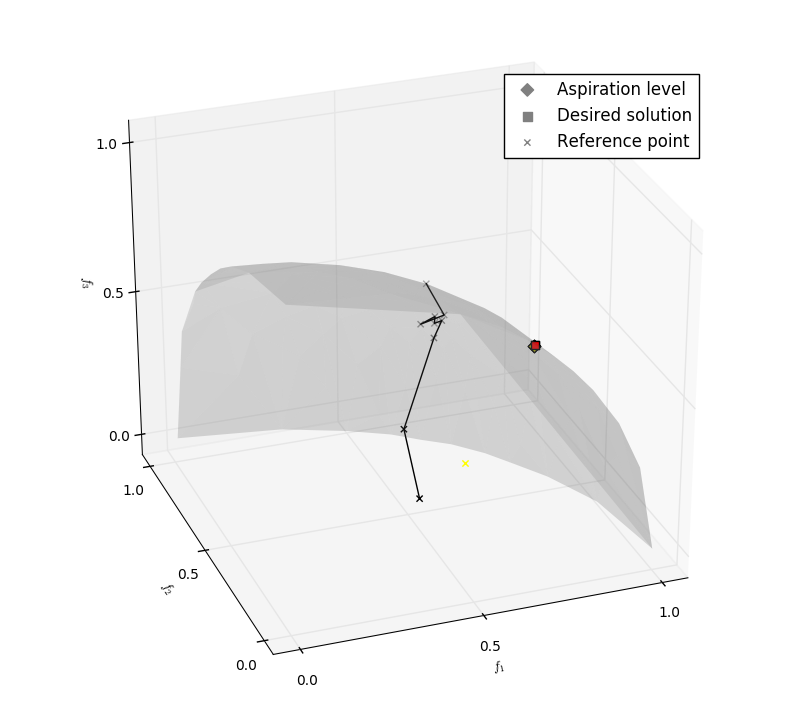

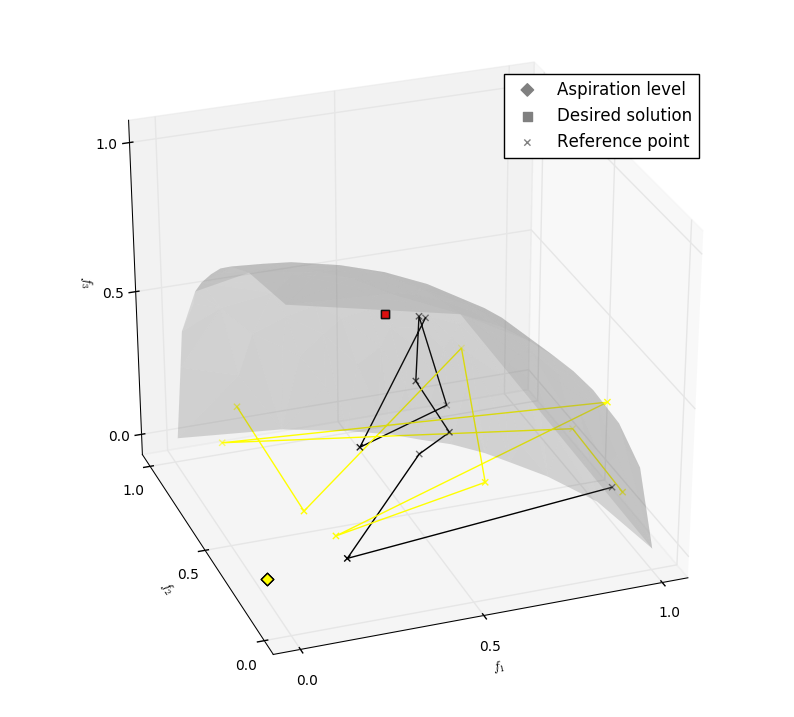

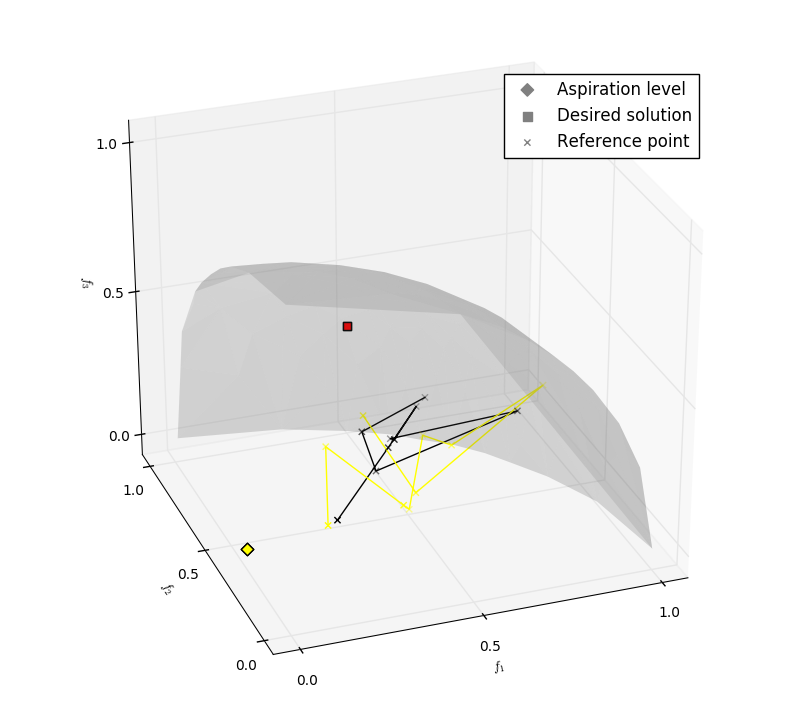

In [12]:
import plot_PPSN2016 as oplt
reload(oplt)
%matplotlib inline
problem="DTLZ2"
display(HTML("<H2>%s ADM reference points</H2>Yellow is iRVEA and black is iK-RVEA"%problem))
for i in range(5):
    fig=oplt.plot([res[(3,'iK-RVEA',problem)][i],res[(3,'iRVEA',problem)][i]],problem=problem,alpha=.2,
                  figsize=(10,9),legend=True)
    fig.show()


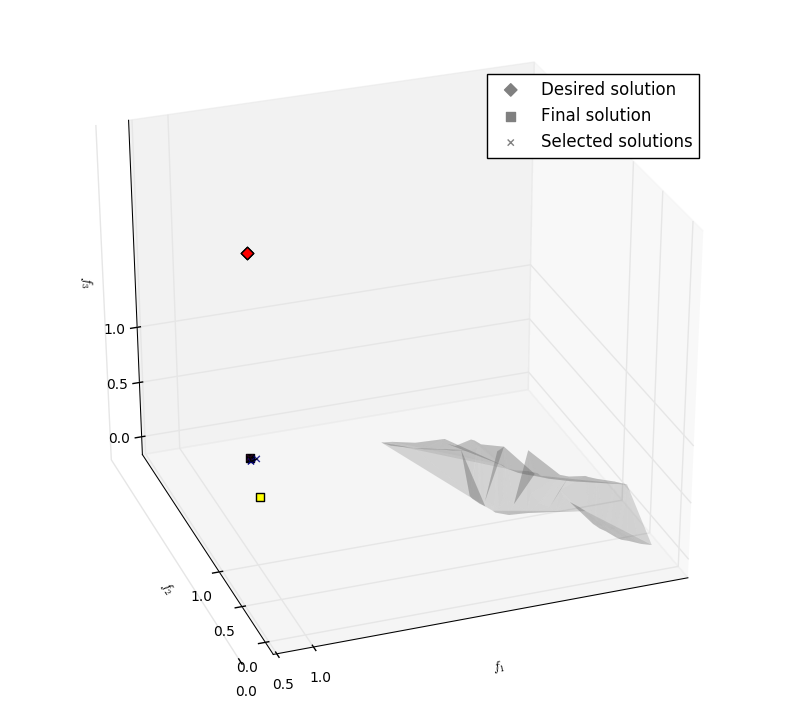

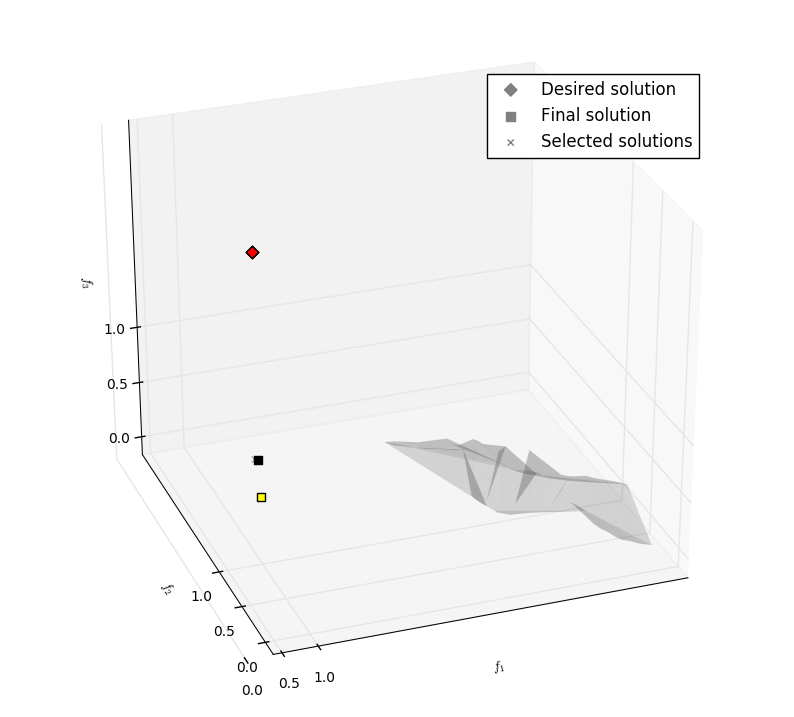

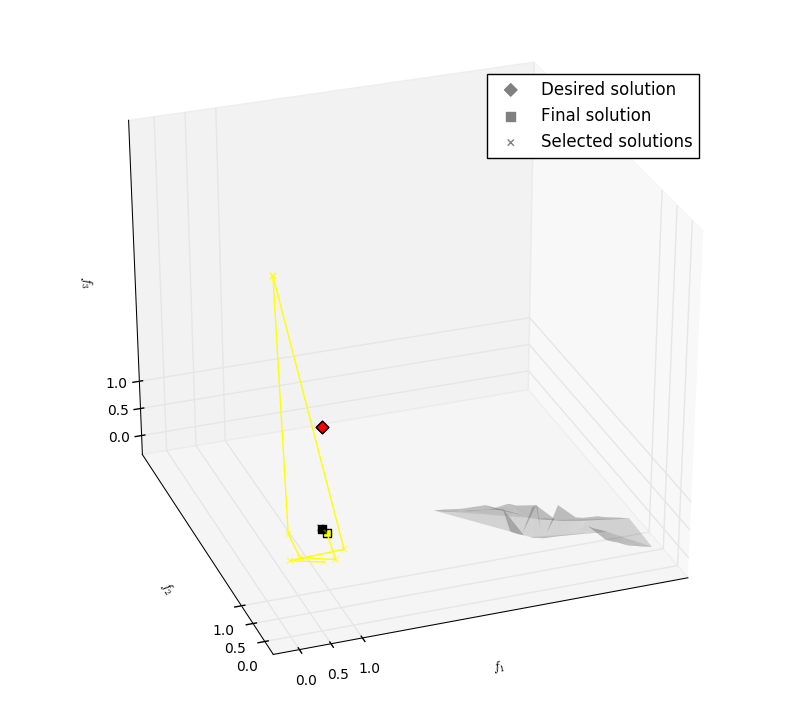

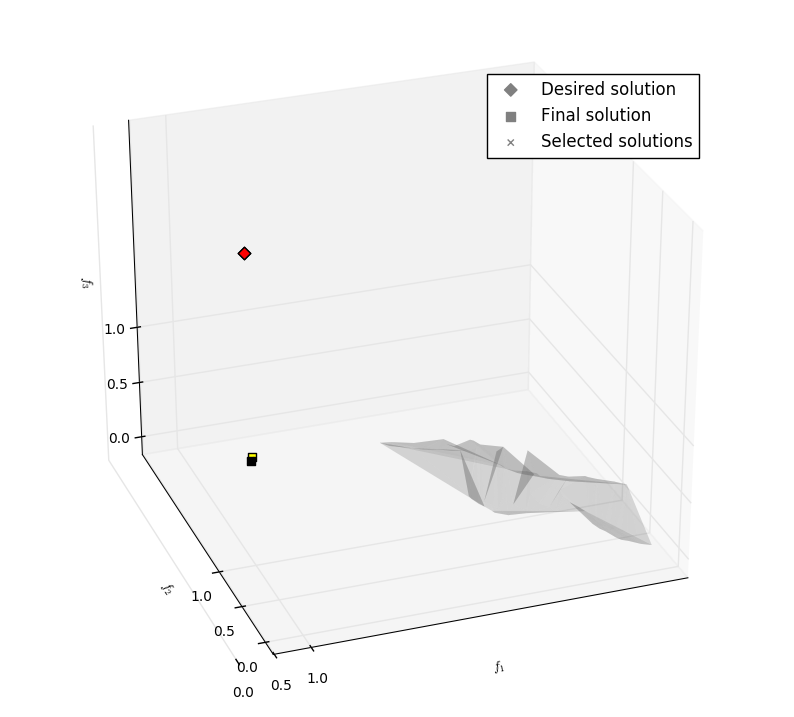

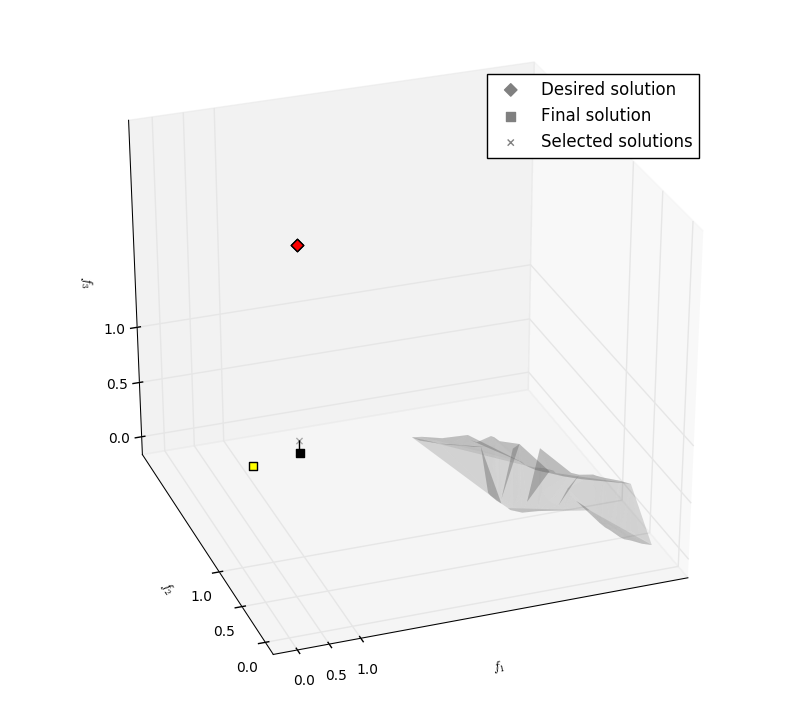

In [13]:
import plot_PPSN2016 as oplt
from IPython.core.display import display, HTML

reload(oplt)
%matplotlib qt
problem="DTLZ7"
display(HTML("<H2>%s ADM PO</H2>Yellow is iRVEA and black is iK-RVEA"%problem))
for i in range(5):
    fig=oplt.plot_dec([res[(3,'iK-RVEA',problem)][i],res[(3,'iRVEA',problem)][i]],problem=problem,alpha=.2,
                  figsize=(10,9),legend=True)
    fig.show()


In [14]:
import os; print(os.environ.get('QT_API'))

None
